In [2]:
# Cell 1: Imports
import os
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


from surprise import Dataset, Reader
from surprise import SVD as SurpriseSVD
from surprise.model_selection import train_test_split
from surprise import accuracy


from collections import defaultdict
import gradio as gr


print('Imports OK')

Imports OK


In [4]:
# %%
# Cell 2: Mount Drive (Colab) & Set DATA_PATH
# If running in Colab, uncomment the mount lines. Otherwise set DATA_PATH to your local CSV path.
# from google.colab import drive
# drive.mount('/content/drive')


# Set the path to your CSV file below. Example Colab path: '/content/drive/MyDrive/personalized_recs_dataset.csv'
DATA_PATH = '/content/drive/MyDrive/personalized_recs_dataset.csv' # <-- EDIT THIS PATH


if not os.path.exists(DATA_PATH):
    print('WARNING: DATA_PATH not found:', DATA_PATH)
    print('Please mount Drive in Colab or update DATA_PATH to point to your CSV file.')
else:
    print('Found DATA_PATH:', DATA_PATH)

Found DATA_PATH: /content/drive/MyDrive/personalized_recs_dataset.csv


In [6]:
# %%
# Cell 3: Load dataset (will raise clear error if path wrong)
print('Loading dataset...')
try:
    df = pd.read_csv(DATA_PATH)
except Exception as e:
    raise RuntimeError(f'Failed to read CSV at {DATA_PATH}: {e}')


print('Raw dataset shape:', df.shape)
print('Columns:', df.columns.tolist())


# Required columns check
required = {'student_id', 'course_id', 'rating'}
if not required.issubset(set(df.columns)):
    raise AssertionError(f'CSV must contain columns: {required}')


# Show a sample
display(df.head())

Loading dataset...
Raw dataset shape: (140320, 3)
Columns: ['student_id', 'course_id', 'rating']


,student_id,course_id,rating
0,861,2-speed-it,1
1,3773,2-speed-it,5
2,3093,2-speed-it,5
3,467,2-speed-it,5
4,4427,2-speed-it,5


In [8]:
# Cell 4: Clean data & consistent dtypes
print('Cleaning data...')
# Drop exact duplicate rows
df = df.drop_duplicates()
# Drop rows with missing core values
df = df.dropna(subset=['student_id', 'course_id', 'rating'])


# Convert IDs to string for consistency (Surprise handles raw ids as strings fine)
df['student_id'] = df['student_id'].astype(str)
df['course_id'] = df['course_id'].astype(str)
# Ratings to float
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
# Drop rows where rating could not be converted
df = df.dropna(subset=['rating'])


# Reset index
df = df.reset_index(drop=True)


print('Cleaned dataset shape:', df.shape)
print('Rating range:', df['rating'].min(), 'to', df['rating'].max())
print('Unique users:', df['student_id'].nunique())
print('Unique courses:', df['course_id'].nunique())

Cleaning data...
Cleaned dataset shape: (129057, 3)
Rating range: 1 to 5
Unique users: 5000
Unique courses: 1835


Quick EDA...


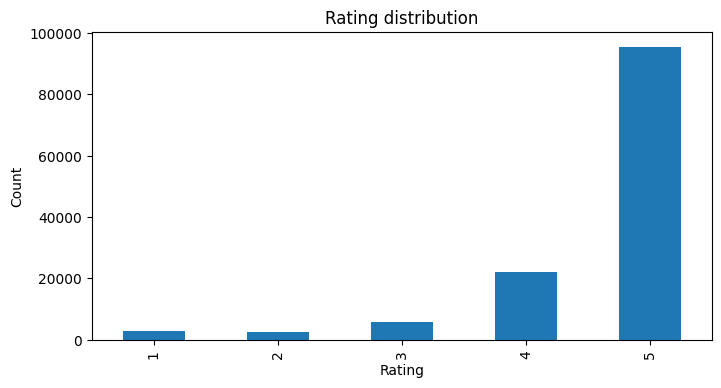

Top 10 courses by interactions:


,count
course_id,
machine-learning,4666
learning-how-to-learn,4351
python,4114
python-data,1982
python-network-data,1625
data-scientists-tools,1542
html-css-javascript,1407
r-programming,1228
grammar-punctuation,1180


Users: 5000, Courses: 1835, Interactions: 129057, Sparsity: 0.9859


In [10]:
# %%
# Cell 5: Quick EDA
print('Quick EDA...')
plt.figure(figsize=(8,4))
df['rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Rating distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


print('Top 10 courses by interactions:')
display(df['course_id'].value_counts().head(10))


n_users = df['student_id'].nunique()
n_items = df['course_id'].nunique()
n_interactions = df.shape[0]
sparsity = 1 - (n_interactions / (n_users * n_items))
print(f'Users: {n_users}, Courses: {n_items}, Interactions: {n_interactions}, Sparsity: {sparsity:.4f}')

In [12]:
# %%
# Cell 6: Build sparse user-item matrix (for clustering/visualization)
print('\nBuilding user-item sparse matrix...')
user_ids = df['student_id'].unique().tolist()
item_ids = df['course_id'].unique().tolist()


user_to_idx = {u: i for i, u in enumerate(user_ids)}
idx_to_user = {i: u for u, i in user_to_idx.items()}


item_to_idx = {it: i for i, it in enumerate(item_ids)}
idx_to_item = {i: it for it, i in item_to_idx.items()}


rows = df['student_id'].map(user_to_idx).to_numpy()
cols = df['course_id'].map(item_to_idx).to_numpy()
vals = df['rating'].to_numpy()


user_item_csr = csr_matrix((vals, (rows, cols)), shape=(len(user_ids), len(item_ids)))
print('CSR shape:', user_item_csr.shape)


Building user-item sparse matrix...
CSR shape: (5000, 1835)


Computing SVD embeddings and clustering...
Cluster sizes: [ 469 2742  457  498  834]


,student_id,cluster
0,861,3
1,3773,3
2,3093,2
3,467,1
4,4427,1


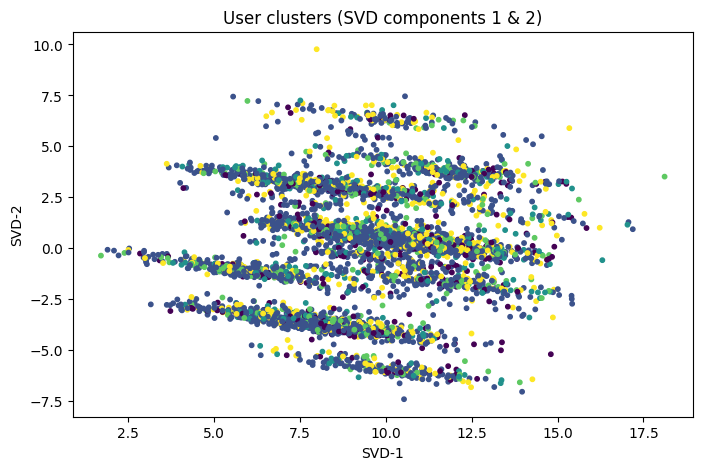

In [14]:
# Cell 7: Dimensionality reduction (TruncatedSVD) + KMeans clustering
print('Computing SVD embeddings and clustering...')
max_possible = min(user_item_csr.shape) - 1
n_components = min(50, max(2, max_possible))
svd = TruncatedSVD(n_components=n_components, random_state=42)
user_emb = svd.fit_transform(user_item_csr)


scaler = StandardScaler()
user_emb_scaled = scaler.fit_transform(user_emb)


n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(user_emb_scaled)
print('Cluster sizes:', np.bincount(clusters))


user_cluster_df = pd.DataFrame({'student_id': user_ids, 'cluster': clusters})
display(user_cluster_df.head())


# Small 2D scatter using first two components
plt.figure(figsize=(8,5))
plt.scatter(user_emb[:,0], user_emb[:,1], c=clusters, s=10)
plt.title('User clusters (SVD components 1 & 2)')
plt.xlabel('SVD-1')
plt.ylabel('SVD-2')
plt.show()

In [16]:
# Cell 8: Train Surprise SVD (collaborative filtering)
print('Training Surprise SVD model...')
rating_min, rating_max = float(df['rating'].min()), float(df['rating'].max())
reader = Reader(rating_scale=(rating_min, rating_max))
data = Dataset.load_from_df(df[['student_id','course_id','rating']], reader)


trainset, testset = train_test_split(data, test_size=0.20, random_state=42)


algo = SurpriseSVD(n_factors=50, n_epochs=20, lr_all=0.005, reg_all=0.02, random_state=42)
algo.fit(trainset)


predictions = algo.test(testset)
print('Test set RMSE and MAE:')
accuracy.rmse(predictions)
accuracy.mae(predictions)

Training Surprise SVD model...
Test set RMSE and MAE:
RMSE: 0.8181
MAE:  0.5569


0.5568963850826768

In [20]:
# Cell 9: Precision@K, Recall@K, Coverage utilities
print('Computing precision/recall@K and coverage (sampled)...')


def precision_recall_at_k(preds, k=5, threshold=None):
    if threshold is None:
        threshold = (rating_max + rating_min) / 2.0

    user_est_true = defaultdict(list)
    for uid, iid, true_r, est, _ in preds:
        user_est_true[uid].append((est, true_r))

    precisions = []
    recalls = []
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        top_k = user_ratings[:k]

        n_rel = sum(1 for (_, true_r) in user_ratings if true_r >= threshold)
        n_rec_k = sum(1 for (est, _) in top_k if est >= threshold)
        n_rel_and_rec_k = sum(1 for (est, true_r) in top_k if (true_r >= threshold and est >= threshold))

        prec = n_rel_and_rec_k / n_rec_k if n_rec_k else 0.0
        rec = n_rel_and_rec_k / n_rel if n_rel else 0.0

        precisions.append(prec)
        recalls.append(rec)

    return np.mean(precisions) if precisions else 0.0, np.mean(recalls) if recalls else 0.0


prec5, rec5 = precision_recall_at_k(predictions, k=5)
print(f'Mean Precision@5: {prec5:.4f}, Mean Recall@5: {rec5:.4f}')

# Coverage@K (use a sample of users to keep runtime reasonable)


def coverage_at_k(model, users, all_items, k=10, sample_limit=200):
    users_sample = users if len(users) <= sample_limit else users[:sample_limit]
    recommended = set()
    for u in users_sample:
        preds_u = [(i, model.predict(u, i).est) for i in all_items]
        topk = sorted(preds_u, key=lambda x: x[1], reverse=True)[:k]
        recommended.update([it for it, _ in topk])
    return len(recommended) / len(all_items) if all_items else 0.0


all_items = df['course_id'].unique().tolist()
all_users = df['student_id'].unique().tolist()
coverage = coverage_at_k(algo, all_users, all_items, k=10, sample_limit=200)
print(f'Coverage@10 (sampled users): {coverage:.4f}')

Computing precision/recall@K and coverage (sampled)...
Mean Precision@5: 0.9669, Mean Recall@5: 0.8820
Coverage@10 (sampled users): 0.1341


In [21]:
# Cell 10: Recommendation function with cold-start handling
print('Preparing recommendation function...')
user_seen = df.groupby('student_id')['course_id'].apply(set).to_dict()
popular_courses = df['course_id'].value_counts().index.tolist()

# Define all_items and all_users within this cell
all_items = df['course_id'].unique().tolist()
all_users = df['student_id'].unique().tolist()

def recommend_courses(user_id, top_n=5):
    uid = str(user_id)
    # Cold-start new user
    if uid not in user_seen:
        return [(c, None) for c in popular_courses[:top_n]]


    seen = user_seen[uid]
    candidates = [c for c in all_items if c not in seen]
    if not candidates:
        fill = [c for c in popular_courses if c not in seen][:top_n]
        return [(c, None) for c in fill]


    scores = []
    for c in candidates:
        try:
            p = algo.predict(uid, c)
            scores.append((c, float(p.est)))
        except Exception:
            # fallback to popularity
            cnt = int((df['course_id'] == c).sum())
            scores.append((c, float(cnt)))


    top_preds = sorted(scores, key=lambda x: x[1], reverse=True)[:top_n]
    return top_preds


# Quick test
sample_user = df['student_id'].iloc[0]
print('Sample recommendations for user', sample_user, '->', recommend_courses(sample_user, top_n=5))

Preparing recommendation function...
Sample recommendations for user 861 -> [('holocaust-introduction-2', 4.785972016240491), ('neurobiology', 4.780672870124974), ('process-mining', 4.778737002801328), ('sanitation', 4.7667541444062635), ('food-beverage-management', 4.764636889186195)]


In [24]:
# Cell 11: Gradio UI (launch this cell to run web UI)
print('Building Gradio interface...')


def recommend_interface(user_id, top_n):
    try:
        uid = str(int(user_id))
    except Exception:
        uid = str(user_id)


    recs = recommend_courses(uid, top_n=top_n)
    rec_df = pd.DataFrame(recs, columns=['course_id', 'predicted_score'])
    rec_df['predicted_score'] = rec_df['predicted_score'].apply(lambda x: f"{x:.2f}" if (x is not None) else 'N/A')


    cluster_label = 'Unknown (new)'
    if uid in user_seen:
        try:
            ui = user_to_idx[uid]
            cluster_label = f'Cluster {clusters[ui]}'
        except Exception:
            pass


    title = f"Recommendations for Student ID: {uid} — {cluster_label}\n"
    return title + '\n' + rec_df.to_string(index=False)


iface = gr.Interface(
    fn=recommend_interface,
    inputs=[gr.Number(label='Student ID (int)'), gr.Slider(minimum=1, maximum=20, step=1, label='Top N', value=5)],
    outputs='text',
    title='🎓 Personalized Learning Recommendation System',
    description='Enter a student ID to get top-N course recommendations. New users get popular course suggestions.'
)


print('To launch the Gradio app, run: iface.launch(share=False)')

Building Gradio interface...
To launch the Gradio app, run: iface.launch(share=False)


In [25]:
# Cell 11: Gradio UI (launch this cell to run web UI)
print('\nBuilding Gradio interface...')

def recommend_interface(user_id, top_n):
    try:
        uid = str(int(user_id))  # Student ID as string
    except Exception:
        uid = str(user_id)

    recs = recommend_courses(uid, top_n=top_n)
    rec_df = pd.DataFrame(recs, columns=['course_id', 'predicted_score'])
    rec_df['predicted_score'] = rec_df['predicted_score'].apply(
        lambda x: f"{x:.2f}" if (x is not None) else 'N/A'
    )

    cluster_label = 'Unknown (new)'
    if uid in user_seen:
        try:
            ui = user_to_idx[uid]
            cluster_label = f'Cluster {clusters[ui]}'
        except Exception:
            pass

    title = f"Recommendations for Student ID: {uid} — {cluster_label}\n"
    return title + "\n" + rec_df.to_string(index=False)

# Build Gradio interface
iface = gr.Interface(
    fn=recommend_interface,
    inputs=[
        gr.Number(label='Student ID (int)'),
        gr.Slider(minimum=1, maximum=20, step=1, label='Top N', value=5)
    ],
    outputs='text',
    title='🎓 Personalized Learning Recommendation System',
    description='Enter a student ID to get top-N course recommendations. New users get popular course suggestions.'
)

# Launch the app (set share=True if you want a public link)
iface.launch(share=False)



Building Gradio interface...
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.
* To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>